# Lesson 07
# Peter Lorenz

In this assignment, we use support vector machines to identify useful predictors for the age of abalones when data about their number of rings is unavailable.

## 0. Preparation

Import the required libraries:

In [66]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import SVR

Set global options:

In [2]:
# Display plots inline
%matplotlib inline

# Display multiple cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Suppress scientific notation
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Declare utility functions:

In [43]:
# Output key metrics
def display_metrics(y_test, y_pred):
    # Display confusion matrix
    print(confusion_matrix(y_test, y_pred))

    # Display performance metrics
    print(classification_report(y_test, y_pred))

    # Compute ROC metrics
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    # Display ROC plot
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    # Display ROC score
    print('Area under the ROC curve (AUC):', roc_auc_score(y_test, y_pred))

Define constants:

In [39]:
CACHE_SIZE=2048

Read and prepare the data:

In [5]:
# Internet location of the data set
url = "https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/Abalone.csv"

# Download the data into a dataframe object
abalone_data = pd.read_csv(url)

# Display shape and initial data
abalone_data.shape
abalone_data.head()

# Examine column types
abalone_data.info()

(4177, 9)

,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
0,M,0.455,0.365,0.095,0.514,0.225,0.101,0.150,15
1,M,0.350,0.265,0.090,0.226,0.100,0.049,0.070,7
2,F,0.530,0.420,0.135,0.677,0.257,0.141,0.210,9
3,M,0.440,0.365,0.125,0.516,0.215,0.114,0.155,10
4,I,0.330,0.255,0.080,0.205,0.089,0.040,0.055,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole Weight    4177 non-null   float64
 5   Shucked Weight  4177 non-null   float64
 6   Viscera Weight  4177 non-null   float64
 7   Shell Weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


One-hot encode the Sex column:

In [9]:
# Use pandas to one-hot encode categorical variables
abalone_data_enc = pd.get_dummies(abalone_data, columns=['Sex'], drop_first=True)

# Display shape and sample contents
abalone_data_enc.shape
abalone_data_enc.head()

(4177, 10)

,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings,Sex_I,Sex_M
0,0.455,0.365,0.095,0.514,0.225,0.101,0.150,15,0,1
1,0.350,0.265,0.090,0.226,0.100,0.049,0.070,7,0,1
2,0.530,0.420,0.135,0.677,0.257,0.141,0.210,9,0,0
3,0.440,0.365,0.125,0.516,0.215,0.114,0.155,10,0,1
4,0.330,0.255,0.080,0.205,0.089,0.040,0.055,7,1,0


We are now ready to build our model.

## 1. Convert continuous output value to binary and build SVC
In this section we convert the continuous output value (Rings) from continuous to binary (0,1) and build an SVC, with class '0' representing specimens less than 11 years old and '1' representing specimens 11 years old and greater. First, we convert the continuous target variable to binary:

In [24]:
# Convert number of rings to binary using 11+ as the cutoff
is_old = np.array(pd.cut(abalone_data_enc['Rings'], [0, 11, 1000], labels=['0', '1'])).astype(int)
is_old

array([1, 0, 0, ..., 0, 0, 1])

We must determine the relative weight of each class by considering its representation in the total:

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Is Older than 10 years old?')]

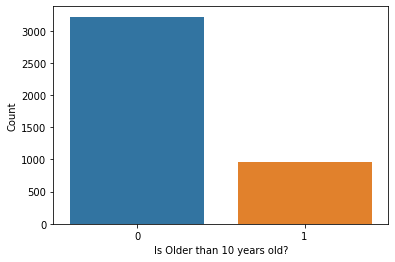

In [31]:
# Plot distribution by output
ax = sns.countplot(x=is_old)
ax.set(xlabel='Is Older than 10 years old?', ylabel='Count')

The population has roughly three times as many members under 11 years old as 11 or older. So we must consider the class weights accordingly below in our models. Fortunately, we can use 'balanced' mode for the class weights, which automatically adjusts the class weights in a manner that is inversely proportional to their frequencies in the input data.

Next we partition the data into training and test sets:

In [29]:
# Model columns
cols = ['Length', 'Diameter', 'Height', 'Whole Weight', 'Shucked Weight', 'Viscera Weight', 
        'Shell Weight', 'Sex_I', 'Sex_M']

# Split data into training and test
X_train, X_test, y_train, y_test = train_test_split(abalone_data_enc[cols], 
                                                    is_old, 
                                                    test_size = 0.1,
                                                    random_state = 0)

# Describe training and test
print("Training data has {} rows.".format(X_train.shape[0]))
print("Test data has {} rows.".format(X_test.shape[0]))

Training data has 3759 rows.
Test data has 418 rows.


Now we build an SVM classifier using the linear kernel:

In [33]:
# Build and fit SVC
svmc = SVC(kernel='linear', class_weight='balanced', cache_size=CACHE_SIZE)
svmc.fit(X_train, y_train)

# Get predictions
y_pred = svmc.predict(X_test)

SVC(C=1.0, break_ties=False, cache_size=2048, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

We have build and fit our SVM classifier. Next we examine its performance.

## 2.  Determine percentage of correctly classified results
In this section we determine the percentage of correctly classified results using our best guess for hyperparameters and kernel. We do this by examining the metrics:

[[261  52]
 [ 28  77]]
              precision    recall  f1-score   support

           0       0.90      0.83      0.87       313
           1       0.60      0.73      0.66       105

    accuracy                           0.81       418
   macro avg       0.75      0.78      0.76       418
weighted avg       0.83      0.81      0.81       418



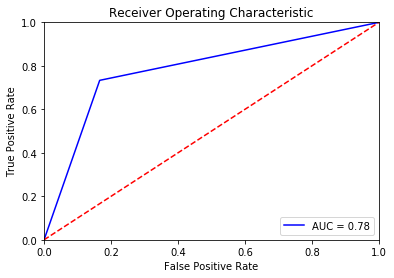

Area under the ROC curve (AUC): 0.7835995740149095


In [44]:
# Display key metrics
display_metrics(y_test, y_pred)

Our initial simplistic SVM classifier did not do badly, with 0.6 precision, 0.73 recall, and 0.78 under the ROC curve. But there remains room for improvement. We now turn to tuning the hyperparameters to extract better performance if possible.

## 3. Test different hyperparameters for each kernel

In this section we find the best hyperparameters for each kernel using sklearn.model_selection.SearchGridCV to determine which kernel performed best with what settings. We begin with the linear kernel, with its single main hyperparameter C. We choose hyperparameters that are exponentially spaced as recommended by https://scikit-learn.org/stable/modules/svm.html#svm-kernels:

In [40]:
# Hyperparameters to test
hyper_parameter_space = {'C': [0.1, 1, 10]}

# Search for best parameters
svc = SVC(cache_size = CACHE_SIZE)
clf = GridSearchCV(svc, hyper_parameter_space, 
                   cv = 5, refit = True, 
                   return_train_score = True)
clf.fit(X_train, y_train)

# Display best parameters
clf.best_estimator_

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=2048,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None, param_grid={'C': [0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

SVC(C=10, break_ties=False, cache_size=2048, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Our search for the best hyperparameters reveals that the model performs better with C=10 than with the default value of C=1. Let's try this model and examine its metrics:

SVC(C=10, break_ties=False, cache_size=2048, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

[[271  42]
 [ 28  77]]
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       313
           1       0.65      0.73      0.69       105

    accuracy                           0.83       418
   macro avg       0.78      0.80      0.79       418
weighted avg       0.84      0.83      0.84       418



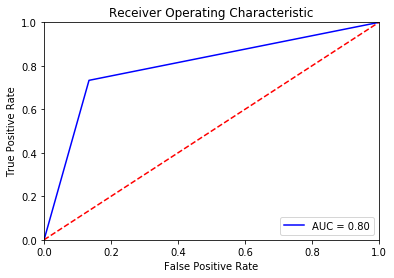

Area under the ROC curve (AUC): 0.7995740149094782


In [45]:
# Build and fit SVC
svmc = SVC(C=10, kernel='linear', class_weight='balanced', cache_size=CACHE_SIZE)
svmc.fit(X_train, y_train)

# Get predictions
y_pred = svmc.predict(X_test)

# Display metrics
display_metrics(y_test, y_pred)

The AUC has improved slightly from 0.78 to 0.8. Recall has remained steady at 0.73, while the precision has increased from 0.6 to 0.65.

Now we experiment with hyperparameters for the more complex kernels, keeping C=10 in line with our linear SVM:

In [52]:
# Hyperparameters to test
hyper_parameter_space = {'kernel': ['poly', 'rbf', 'sigmoid'], 
                         'degree': [2, 3, 4]}

# Search for best parameters
svc = SVC(C=10, cache_size = CACHE_SIZE)
clf = GridSearchCV(svc, hyper_parameter_space, 
                   cv = 5, refit = True, 
                   return_train_score = True)
clf.fit(X_train, y_train)

# Display best parameters
clf.best_estimator_

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=10, break_ties=False, cache_size=2048,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'degree': [2, 3, 4],
                         'kernel': ['poly', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

SVC(C=10, break_ties=False, cache_size=2048, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Our search of hyperparameters among the other kernels identifies the best model as kernel='rbf' and degree='2'. We build and fit this model and display the metrics:

SVC(C=1.0, break_ties=False, cache_size=2048, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=2, gamma='scale',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

[[261  52]
 [ 24  81]]
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       313
           1       0.61      0.77      0.68       105

    accuracy                           0.82       418
   macro avg       0.76      0.80      0.78       418
weighted avg       0.84      0.82      0.82       418



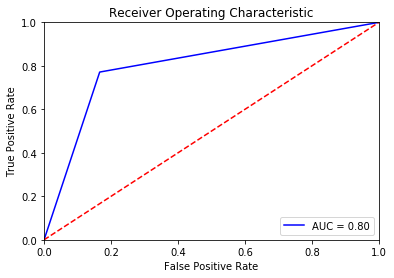

Area under the ROC curve (AUC): 0.8026471930625285


In [54]:
# Build and fit SVC
svmc = SVC(kernel='rbf', degree=2, class_weight='balanced', cache_size=CACHE_SIZE)
svmc.fit(X_train, y_train)

# Get predictions
y_pred = svmc.predict(X_test)

# Display metrics
display_metrics(y_test, y_pred)

Our model using the radial-basis function kernel with degree=2 performs essentially the same as our model using the linear kernel, with recall slightly better (0.77 vs. 0.73), precision slightly worse (0.61 vs. 0.65), f1 score slightly worse (0.68 vs. 0.69), and AUC the same (0.80). Appealing to Occam's razor, we go with the simpler linear model as our best model.

## 4. Show recall, precision and f-measure for the best model

In this section we report the recall, precision, and f-measure for the best model, which is the model with the linear kernel and C=10, which have already been listed above. These values are:

- Recall:    0.73
- Precision: 0.65
- F1 score:  0.69

## 5. Create an SVR model using the original data

In this section we create an SVR model using the original data with rings as a continuous variable. We should point out the inherent problem in treating number of rings as a continuous variable, given that it is not represented by the continuous real numbers, but by discrete states that happen to be ranked sequentially.

In [70]:
# Build and fit SVR
svmr = SVR(C=10, cache_size=CACHE_SIZE)
svmr.fit(X_train, y_train)

# Get predictions
y_pred = svmr.predict(X_test)

# Display metrics
print('R squared:          ', round(svmr.score(X_test, y_test), 3))
print('Mean-squared error: ', round(mean_squared_error(y_test, y_pred), 3))
print('Explained variance: ', round(explained_variance_score(y_test, y_pred), 3))

SVR(C=10, cache_size=2048, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

R squared:           0.255
Mean-squared error:  0.14
Explained variance:  0.299


The low value of R squared and explained variance suggest that the regression model does not do a great job of accounting for variability in the data set. In addition, we would prefer the mean-squared error to be closer to zero to have confidence that our model fits the data points in a way that is more helpful than simply predicting from the mean. The poor performance of the regression model is not terribly surprising considering that the target is not strictly continuous. Regression is just not the best tool here.

## 6. Report on the predicted variance and the mean squared error

In this section we report on the predicted variance and the mean squared error, which are as follows (from above):

- Mean-squared error:  0.14
- Explained variance:  0.30

## Summary

In this assignment we applied support vector machines (SVM's) to the task of predicting the number of rings found in abalone shells and, hence, the age of the abalone from other physical features that are easier to measure than the number of rings. We produced two types of models: a support vector classifier (SVC) and a support vector regressor (SVR). The SVC performed better than the SVR, though of course it was only able to tell us whether or not the abalone was likely to be 11 years old or older, rather than give us a specific age as the SVR attempts to do. Our best SVC model was able to predict this with 0.73 recall and 0.65 precision. Although these numbers are not terrible, they do suggest that a significant amount of the variation within the species is not correlated with age. As the data set background suggests, we may have to include environmental data to improve the model further.